In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

import sklearn

RANDOM_STATE = 123

In [3]:
smt_2020_df = pd.read_excel('data/I11_SMT Incidents 2020.xlsx')

smt_2020_df.columns = smt_2020_df.iloc[11].values
smt_2020_df = smt_2020_df.iloc[12:]
smt_2020_df = smt_2020_df.reset_index(drop=True)


c:\ProgramData\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
smt_2021_df = pd.read_excel('data/I11_SMT Incidents 2021.xlsx')

smt_2021_df.columns = smt_2021_df.iloc[11].values
smt_2021_df = smt_2021_df.iloc[12:]
smt_2021_df = smt_2021_df.reset_index(drop=True)

In [5]:
smt_2022_df = pd.read_excel('data/I11_SMT Incidents 2022.xlsx')

smt_2022_df.columns = smt_2022_df.iloc[11].values
smt_2022_df = smt_2022_df.iloc[12:]
smt_2022_df = smt_2022_df.reset_index(drop=True)

In [6]:
smt_df = pd.concat([smt_2020_df, smt_2021_df, smt_2022_df])
smt_df.reset_index(drop=True,inplace=True)

pd.set_option('display.max_columns', None)

In [7]:
celonis_2020_df = pd.read_excel('data/Tickets_Celonis_2020.xlsx')
celonis_2020_df = celonis_2020_df.reset_index(drop=True)

In [8]:
celonis_2021_df = pd.read_excel('data/Tickets_Celonis_2021.xlsx')
celonis_2021_df = celonis_2021_df.reset_index(drop=True)

In [9]:
celonis_2022_df = pd.read_excel('data/Tickets_Celonis_2022.xlsx')
celonis_2022_df = celonis_2022_df.reset_index(drop=True)

In [10]:
celonis_df = pd.concat([celonis_2020_df, celonis_2021_df, celonis_2022_df])
celonis_df.reset_index(drop=True,inplace=True)

In [11]:
#Posibles a borrar ['Current Incident Type', 'Region', 'Impact', 'Site','Product Categorization Tier 1', 'Resolution Categorization Tier 1', 'Resolution Categorization Tier 2', ]
#Posibles a no borrar ['Customer Department', 'Primary Center Code']

no_borrados_para_analisis = ['Status Reason', 'Customer Department', 'Desk Location', 'Impact', 'Service+', 'CI+', 'Resolution Categorization Tier 3', 'Desk Location']

smt_df_clean = smt_df.drop(['Original Incident Number', 'Requisition ID', 'Created Date (UTC+0)', 'Status', 'Status Reason', 'Customer Department', 'Summary', 'Desk Location', 'Impact', 'In Progess Time (hhh:mi)\n', 'Actual Duration/Open Time (hhh:mi)',
                                         'Down Time of CI-Unavailability (hhh:mi)', 'Last Modified Date (UTC+0)', 'First Resolved Date (UTC+0)', 'Last Resolved Date (UTC+0)', 'Created Month', 'Service+', 'CI+', 'Product Name', 
                                         'Resolution Categorization Tier 3', 'Resolution Product Name', 'Primary Center Code', 'Target Date', 'Notes', 'Resolution', 'Open Priority', 'Current Priority', 'Region'], axis=1)

smt_df_clean.dropna(inplace=True)

In [12]:
#Posibles a borrar ['Site Group', 'Submitter Group', 'Resolver Organization']
#Posibles a no borrar ['Template Name', 'User Company']
celonis_no_borrados_para_analisis = ['Service Name', 'Template Name', 'User Company', 'CI']

celonis_df_clean = celonis_df.drop(['Submit Date', 'Service Name', 'Ticket Summary', 'Last Resolution Date', 'Template Name', 'User Company', 'Requisition ID', 'CI', 'Site', 'Site Group', 'Reported Source', 'Status', 'Resolver Organization'], axis=1)
celonis_df_clean.dropna(inplace=True)

In [13]:
combined_df = pd.merge(celonis_df_clean, smt_df_clean, how='inner', left_on='Incident Number', right_on='Incident ID')
combined_df.drop(['Incident ID'], axis=1, inplace=True) #Comprobar Target Date

In [14]:
combined_df

,Incident Number,Incident Type,Submitter Group,Last Assigned Organization,Last Assigned Group,Entry Channel,Last Resolution Time,Priority,Open Incident Type,Current Incident Type,Company,Site Group,Site,Reported Source,Assigned Group,Assigned Group Department,Operational Categorization Tier 1,Operational Categorization Tier 2,Operational Categorization Tier 3,Product Categorization Tier 1,Product Categorization Tier 2,Product Categorization Tier 3,Resolution Categorization Tier 1,Resolution Categorization Tier 2,Resolution Product Categorization Tier 1,Resolution Product Categorization Tier 2,Resolution Product Categorization Tier 3,Created by CI-Hotline
0,INC000017348507,User Service Request,ITSD - IT Service Desk,Regional Services World,Iberia4 -Md-,CI-Hotline / ITSD,260.087222,Medium,Not assigned,User Service Request,AE,ES,MD1,Phone,Iberia4 -Md-,CI/CER-IB,Request,- None -,- None -,Service,Infrastructure Service,Support Service,Request,User Rights,Service,Infrastructure Service,Support Service,Yes
1,INC000017354421,User Service Request,ITSD - IT Service Desk,Regional Services World,Iberia4 -Md-,CI-Hotline / ITSD,205.333889,Medium,Not assigned,User Service Request,AE,ES,MD1,Phone,Iberia4 -Md-,CI/CER-IB,Request,Modify,- None -,Service,Infrastructure Service,Support Service,Request,User Rights,Service,Infrastructure Service,Support Service,Yes
2,INC000017400389,User Service Request,ITSD - IT Service Desk,Regional Services World,Iberia4 -Md-,CI-Hotline / ITSD,22.029167,Medium,Not assigned,User Service Request,AE,ES,MD1,Email,Iberia4 -Md-,CI/CER-IB,Request,- None -,- None -,Service,Infrastructure Service,Support Service,Request,- None -,Service,Infrastructure Service,Support Service,Yes
3,INC000017470045,User Service Request,ITSD - IT Service Desk,Regional Services World,Iberia4 -Md-,IT Service Portal,502.823333,Low,Not assigned,User Service Request,M,ES,MD1,Walk In,Iberia4 -Md-,CI/CER-IB,Request,- None -,- None -,Service,End Device Service,Mobile Device Service,Request,- None -,Service,End Device Service,Mobile Device Service,Yes
4,INC000017470799,User Service Request,ITSD - IT Service Desk,Regional Services World,Iberia4 -Md-,IT Service Portal,475.007778,Low,Not assigned,User Service Request,TT,ES,MD,Other,Iberia4 -Md-,CI/CER-IB,Request,- None -,- None -,Service,End Device Service,Mobile Device Service,Request,- None -,Service,End Device Service,Mobile Device Service,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11745,INC000023672067,User Service Request,ITSD - IT Service Desk,Regional Services EMEA,Spain1,IT Service Portal,164.219167,Low,User Service Request,User Service Request,PS,ES,AJ,Self Service,Spain1,BD/PFE-IA,Request,- None -,- None -,Service,Infrastructure Service,Support Service,Request,- None -,Service,Infrastructure Service,Support Service,Yes
11746,INC000023672229,User Service Restoration,ITSD - ES,Regional Services EMEA,Spain1,CI-Hotline / ITSD,23.933889,Low,User Service Restoration,User Service Restoration,C,ES,MD,Phone,Spain1,BD/PFE-IA,Failure,Application,- None -,Service,Application Service,Application Service,Handling,Unclear,Service,Application Service,Application Service,Yes
11747,INC000023674299,User Service Restoration,ITSD - IT Service Desk,Regional Services EMEA,Spain1,CI-Hotline / ITSD,0.578333,Low,User Service Restoration,User Service Restoration,GS,ES,MD,Phone,Spain1,BD/PFE-IA,Failure,- None -,- None -,Service,IT Service,IT Service,Handling,Unclear,Service,IT Service,IT Service,Yes
11748,INC000023674336,User Service Request,Spain1,Regional Services EMEA,Spain1,IT Personal Support,0.020556,Low,User Service Request,User Service Request,AE,ES,MD1,Walk In,Spain1,BD/PFE-IA,Request,- None -,- None -,Service,IT Service,IT Service,Request,- None -,Service,IT Service,IT Service,No


In [15]:
"""Q1 = combined_df['Last Resolution Time'].quantile(0.1)
Q3 = combined_df['Last Resolution Time'].quantile(0.9)
IQR = Q3 - Q1

# Filtra las filas que no son outliers
combined_df = combined_df[combined_df['Last Resolution Time'] <= Q3 + 1.5 * IQR]
combined_df.shape"""

"Q1 = combined_df['Last Resolution Time'].quantile(0.1)\nQ3 = combined_df['Last Resolution Time'].quantile(0.9)\nIQR = Q3 - Q1\n\n# Filtra las filas que no son outliers\ncombined_df = combined_df[combined_df['Last Resolution Time'] <= Q3 + 1.5 * IQR]\ncombined_df.shape"

In [16]:
combined_df['Is On Time'] = (combined_df['Last Resolution Time'] <= 1).astype(int)
combined_df.drop(['Last Resolution Time'], axis=1, inplace=True)

In [17]:
isOnTime_counts = combined_df['Is On Time'].value_counts()
isOnTime_counts

1    6390
0    5360
Name: Is On Time, dtype: int64

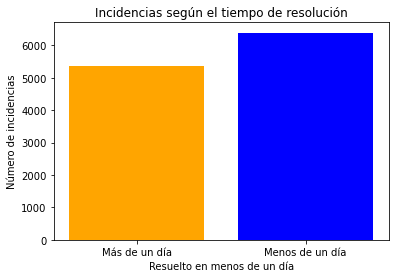

In [18]:
plt.bar(isOnTime_counts.index, isOnTime_counts.values, color=['blue', 'orange'])

# Añadir etiquetas y título
plt.xlabel('Resuelto en menos de un día')
plt.ylabel('Número de incidencias')
plt.title('Incidencias según el tiempo de resolución')

# Personalizar las etiquetas del eje x
plt.xticks(isOnTime_counts.index, ['Menos de un día', 'Más de un día'])

# Mostrar el gráfico
plt.show()

<AxesSubplot:ylabel='Is On Time'>

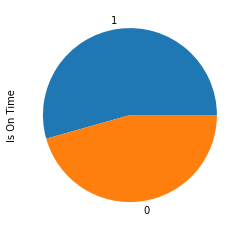

In [19]:
isOnTime_counts.plot.pie()

In [20]:
columns_list = combined_df.columns
columns_list = [elem for elem in columns_list if elem not in ['Incident Number', 'Is On Time']] 
combined_df_one_hot = pd.get_dummies(combined_df, columns=columns_list)
combined_df_one_hot.shape

(11750, 240)

In [21]:
X = combined_df_one_hot.drop(['Incident Number', 'Is On Time'], axis=1).values
y = combined_df_one_hot['Is On Time'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [22]:
if (sklearn.__version__ < "1.1.0"):
    funcion_coste = 'log'
else:
    funcion_coste = 'log_loss'
funcion_coste

'log_loss'

Precisión (Acurracy) :  88.09%
Puntuación de validación cruzada(Cross Validation Score) con Train :  93.82%
Puntuación ROC_AUC :  89.13%


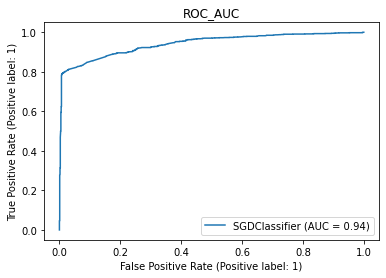

              precision    recall  f1-score   support

           0       0.80      0.99      0.88      1045
           1       0.99      0.80      0.88      1305

    accuracy                           0.88      2350
   macro avg       0.89      0.89      0.88      2350
weighted avg       0.90      0.88      0.88      2350



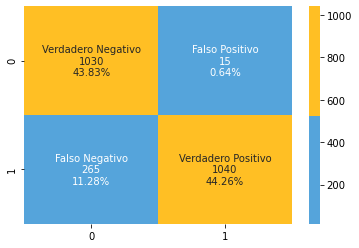

In [23]:
log_classifier = SGDClassifier(loss=funcion_coste,  fit_intercept=True, random_state=RANDOM_STATE)

log_classifier.fit(X_train, y_train)
prediction = log_classifier.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

print("Precisión (Acurracy) : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
print("Puntuación de validación cruzada(Cross Validation Score) con Train : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_train,y_train, cv = cv ,scoring = 'roc_auc').mean()))
#print("Puntuación de validación cruzada(Cross Validation Score) con Val : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_val_OH_sc,y_val_OH, cv = cv ,scoring = 'roc_auc').mean()))
print("Puntuación ROC_AUC : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))

RocCurveDisplay.from_estimator(log_classifier, X_test,y_test)
plt.title('ROC_AUC')
plt.show()

colores = ['#55A4DB','#FFBF24']
# Matriz de confusión

cm = confusion_matrix(y_test, prediction)
nombres = ['Verdadero Negativo','Falso Positivo','Falso Negativo','Verdadero Positivo']
counts = [value for value in cm.flatten()]
porcentajes = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
etiquetas = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nombres,counts,porcentajes)]
etiquetas = np.asarray(etiquetas).reshape(2,2)
sns.heatmap(cm,annot = etiquetas,cmap = colores,fmt ='')

# Informe con clasificaciones
print(classification_report(y_test, prediction))


Precisión (Acurracy) :  86.38%
Puntuación ROC_AUC :  86.58%


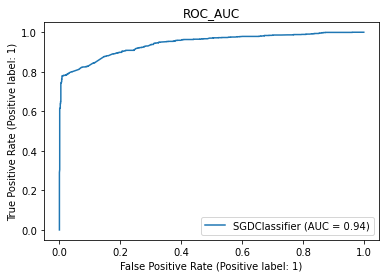

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1071
           1       0.90      0.84      0.87      1279

    accuracy                           0.86      2350
   macro avg       0.86      0.87      0.86      2350
weighted avg       0.87      0.86      0.86      2350



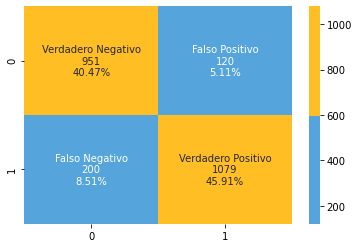

In [24]:
RANDOM_STATE = 9678
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
log_classifier = SGDClassifier(loss=funcion_coste,  fit_intercept=True, random_state=RANDOM_STATE)

log_classifier.fit(X_train, y_train)
prediction = log_classifier.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

print("Precisión (Acurracy) : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
#print("Puntuación de validación cruzada(Cross Validation Score) con Train : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_train,y_train, cv = cv ,scoring = 'roc_auc').mean()))
#print("Puntuación de validación cruzada(Cross Validation Score) con Val : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_val_OH_sc,y_val_OH, cv = cv ,scoring = 'roc_auc').mean()))
print("Puntuación ROC_AUC : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))

RocCurveDisplay.from_estimator(log_classifier, X_test,y_test)
plt.title('ROC_AUC')
plt.show()

colores = ['#55A4DB','#FFBF24']
# Matriz de confusión

cm = confusion_matrix(y_test, prediction)
nombres = ['Verdadero Negativo','Falso Positivo','Falso Negativo','Verdadero Positivo']
counts = [value for value in cm.flatten()]
porcentajes = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
etiquetas = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nombres,counts,porcentajes)]
etiquetas = np.asarray(etiquetas).reshape(2,2)
sns.heatmap(cm,annot = etiquetas,cmap = colores,fmt ='')

# Informe con clasificaciones
print(classification_report(y_test, prediction))


In [25]:
X_test_df = pd.DataFrame(X_test, columns=combined_df_one_hot.drop(['Incident Number', 'Is On Time'], axis=1).columns)
y_test_df = pd.DataFrame(y_test, columns=['Is On Time'])

y_test_df

,Is On Time
0,0
1,0
2,0
3,1
4,0
...,...
2345,0
2346,0
2347,1
2348,0


In [27]:
explainer = ClassifierExplainer(log_classifier, X_test_df, y_test_df)

ExplainerDashboard(explainer).run()

Note: model_output='probability' is currently not supported for linear classifiers models with shap. So defaulting to model_output='logodds' If you really need probability outputs use shap='kernel' instead.
Note: shap values for shap='linear' get calculated against X_background, but paramater X_background=None, so using X instead...
Generating self.shap_explainer = shap.LinearExplainer(model, X)...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Ca

C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature names

C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature names

C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature names

C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature names

C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature names

C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature

Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.1.40:8050


C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature names



ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8050): Max retries exceeded with url: /_alive_3ec90906-d168-4759-abd9-b50b7ddd8691 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002549543A220>: Failed to establish a new connection: [WinError 10049] La dirección solicitada no es válida en este contexto'))

C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature names

C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature names

C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature names

C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature names

C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature names

C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but SGDClassifier was fitted without feature